# Project Matcha
The Japanese Language Proficiency Test (JLPT) is the most recognized Japanese language examination out there. It evaluates vocabulary, listening, and readinf comprehension and it is divided into 5 levels of difficulty - N5 being the most basic and N1 being the most advanced - that the applicant can choose from. Performing well in it will most likely open doors to whoever intends to work and live in Japan.

This project extracts JLPT data and perform some basic exploratory analysis on it. Even though data is downloadable from JLPT's official website, it is all divided into several PDF files that would probably take a whole day for the analyst to input, clean and reconcile everything into a CSV file. Below, I test **pdfplumber** - a library specifically built to extract data from PDF. Then, I load the data into a Tableau file and perform some exploratory analysis.

In [249]:
# Import relevant libraries
import pdfplumber
import pandas as pd

### Extract the Data
As shown below, I have all pdf files saved into my workspace. Each PDF file has 3-5 pages of tables containing the list of cities associated with the number of applicants and test takers for each difficult level of JPLT. The PDF is faily well structured, which will probably make extraction easier, but it is not guaranteed that all PDFs look exactly the same (has the same number of columns / rows or is placed at the same spot on the page).   

In [250]:
rawpdf = [
    "2010_2_3.pdf",
    "2011_2_3.pdf",
    "2012_2_3.pdf",
    "2013_2_3.pdf",
    "2014_2_3.pdf",
    "2015_2_3.pdf",
    "2016_2_3.pdf",
    "2017_2_3.pdf",
    "2018_2_3.pdf",
    "2019_2_3.pdf"
]

extract = []

# For loop that will extract data from each page of each PDF
for loadpdf in rawpdf:
    p = pdfplumber.open(loadpdf)
    for n in p.pages:
        pnumber = n.page_number-1
        extract.append(p.pages[pnumber].extract_tables(table_settings={"vertical_strategy": "lines_strict","horizontal_strategy": "text","min_words_horizontal":12}))

It is important to set **table_settings** in the best way possible. In the code above, `"vertical_strategy": "lines_strict"` will force pdfplumber to look at vertical lines and `"horizontal_strategy": "text"` will let it look at the horizontal alignment of text for data parsing. Checking how the tables in the PDF are built, we can see that there are no horizontal lines that divide city data. (for example, if we set `"horizontal_strategy": "lines_strict"` it would fail to bring the data that I want).

I also set `"min_words_horizontal":12` which tells pdfplumber that rows that have less than 12 words can be discarded.

See below the specific area that I extract from the PDFs

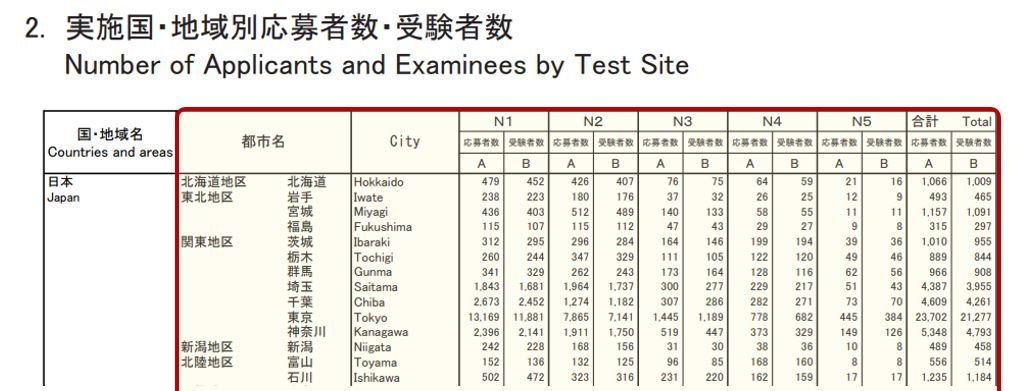

In [299]:
# Let's check the extracted data. For example: Hokkaido looks like this.
print(extract[0][0][3])
print(extract[0][0][4])
print(extract[0][0][5])
print(extract[0][0][6])
print(extract[0][0][7])

['北海道地区 北海道', 'Hokkaido', '479', '452', '426', '407', '76', '75', '64', '59', '21', '16', '1,066']
['東北地区 岩手', 'Iwate', '238', '223', '180', '176', '37', '32', '26', '25', '12', '9', '493']
['宮城', 'Miyagi', '436', '403', '512', '489', '140', '133', '58', '55', '11', '11', '1,157']
['福島', 'Fukushima', '115', '107', '115', '112', '47', '43', '29', '27', '9', '8', '315']
['関東地区 茨城', 'Ibaraki', '312', '295', '296', '284', '164', '146', '199', '194', '39', '36', '1,010']


Data is extracted and each row is stored ins lists. As shown above, data for Hokkaido (Island in the North of Japan), Iwate, Miyagi, Fukushima, and Ibaraki looks correct. Pdfplumber just failed to extract the last element in the total column (check pdf screenshot above). I will proceed with the work as the last two columns will not be used for the analysis - as the name suggest, they are just the grand totals of the column that were successfully extracted.

Next step is to do some data cleasing and processing. We want to stre this data into a dataframe.

### Clean the Data

In [228]:
# Remove unnecessary columns
cleanlist = []
for p in list(range(len(extract))):
    for i in extract[p][0]:
        if all(i[-13:]):
            cleanlist.append(i[-14:])
        
df_jlpt = pd.DataFrame(cleanlist)

In [230]:
# Let's add test date labels
period = ["2010 Dec","2010 Dec","2011 Dec","2012 Dec","2013 Dec","2014 Dec","2015 Dec","2016 Dec","2017 Dec","2018 Dec","2019 Dec"]
percol = []
n = 0

for i in df_jlpt[1]:
    if i == "Hokkaido":
        n+=1
    percol.append(period[n])
    
df_jlpt["file"] = percol
df_jlpt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,file
0,都市名,City,応募者数,受験者数,応募者数,受験者数,応募者数,受験者数,応募者数,受験者数,応募者数,受験者数,応募者数,None,2010 Dec
1,北海道地区 北海道,Hokkaido,479,452,426,407,76,75,64,59,21,16,"1,066",None,2010 Dec
2,東北地区 岩手,Iwate,238,223,180,176,37,32,26,25,12,9,493,None,2010 Dec
3,宮城,Miyagi,436,403,512,489,140,133,58,55,11,11,"1,157",None,2010 Dec
4,福島,Fukushima,115,107,115,112,47,43,29,27,9,8,315,None,2010 Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,アビジャン,Abidjan,0,0,4,3,5,4,8,7,16,12,33,26,2019 Dec
2571,キンシャサ,Kinshasa,0,0,0,0,0,0,1,1,46,21,47,22,2019 Dec
2572,コトヌ,Cotonou,0,0,4,3,6,6,13,12,27,26,50,47,2019 Dec
2573,アンタナナリボ,Antananarivo,1,1,7,6,33,30,51,43,140,116,232,196,2019 Dec


In [231]:
# Now I rename columns
oldcols = list(range(0,14,1))
newcols = "city_jp city_en n1_applied n1_tstaken n2_applied n2_tstaken n3_applied n3_tstaken n4_applied n4_tstaken n5_applied n5_tstaken".split()
cols = list(zip(oldcols,newcols))
cold = dict(cols)

# Remove unnecessary rows
df_jlpt1 = df_jlpt[df_jlpt[2]!="応募者数"]
df_jlpt1.rename(columns=cold, inplace = True)

In [462]:
# Remove unnecessary columns
df_jlpt2 = df_jlpt1.drop([12,13], axis=1)

In [485]:
# Set data types correctly 
cols = "n1_applied n1_tstaken n2_applied n2_tstaken n3_applied n3_tstaken n4_applied n4_tstaken n5_applied n5_tstaken".split()
df_jlpt2[cols] = df_jlpt2[cols].replace({',': ''}, regex=True).astype("int")

In [486]:
# Check data
df_jlpt2[df_jlpt2["city_en"]=="Yangon"]

,city_jp,city_en,n1_applied,n1_tstaken,n2_applied,n2_tstaken,n3_applied,n3_tstaken,n4_applied,n4_tstaken,n5_applied,n5_tstaken,file
339,ヤンゴン,Yangon,163,143,428,376,415,354,517,437,548,415,2011 Dec
579,ヤンゴン,Yangon,203,181,485,441,299,257,620,541,813,602,2012 Dec
827,ヤンゴン,Yangon,271,235,459,412,555,473,1085,927,1710,1242,2013 Dec
1078,ヤンゴン,Yangon,288,239,514,458,852,737,1434,1173,2584,1827,2014 Dec
1339,ヤンゴン,Yangon,325,259,610,529,1007,846,1979,1575,3297,2314,2015 Dec
1603,ヤンゴン,Yangon,364,286,660,539,1374,1162,2858,2301,5330,3684,2016 Dec
1875,ヤンゴン,Yangon,478,369,1049,896,2462,2088,4682,3711,7676,5420,2017 Dec
2155,ヤンゴン,Yangon,436,338,1319,1125,2669,2284,5937,4812,7916,5818,2018 Dec
2442,ヤンゴン,Yangon,577,454,1808,1551,5025,4320,9999,8563,9999,7216,2019 Dec


In [487]:
# Check data types
df_jlpt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2526 entries, 1 to 2574
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city_jp     2526 non-null   object
 1   city_en     2526 non-null   object
 2   n1_applied  2526 non-null   int64 
 3   n1_tstaken  2526 non-null   int64 
 4   n2_applied  2526 non-null   int64 
 5   n2_tstaken  2526 non-null   int64 
 6   n3_applied  2526 non-null   int64 
 7   n3_tstaken  2526 non-null   int64 
 8   n4_applied  2526 non-null   int64 
 9   n4_tstaken  2526 non-null   int64 
 10  n5_applied  2526 non-null   int64 
 11  n5_tstaken  2526 non-null   int64 
 12  file        2526 non-null   object
dtypes: int64(10), object(3)
memory usage: 340.8+ KB


In [234]:
# Data is ready. Let's export to csv.
df_jlpt2.to_csv("df_jlpt.csv")

### Visualize and Explore
The hard part of the work is done. I successfully extracted data from several PDF files, applied proper data cleasing, and now I exported it into a CSV format. The data is ready to be analyzed. Let's quickly check some visuals using matplotlib.

In [516]:
# Let's have a a look at the data for N5 test takers
N5 = df_jlpt2[["city_en", "n5_tstaken", "file"]]

# Sum the number of N5 test takers
N5.groupby("file").agg("sum")

,n5_tstaken
file,
2010 Dec,36625
2011 Dec,30640
2012 Dec,30931
2013 Dec,33280
2014 Dec,37188
2015 Dec,40577
2016 Dec,47886
2017 Dec,53053
2018 Dec,59643


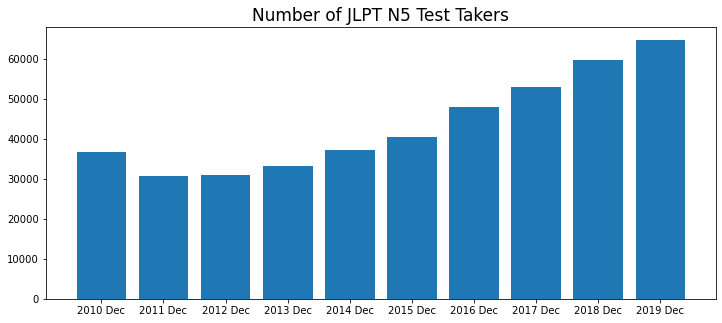

In [526]:
import matplotlib.pyplot as plt
print()
plt.figure(figsize=(12, 5))
plt.bar(N5.groupby("file").agg("sum").index, N5.groupby("file").agg("sum")["n5_tstaken"])
plt.title("Number of JLPT N5 Test Takers", fontsize=17)
plt.show()

Number of test takers is growing over time

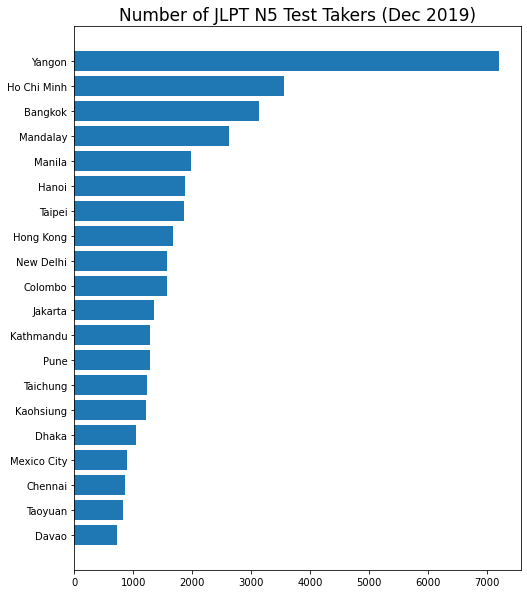

In [550]:
print()
plt.figure(figsize=(8, 10))
top20 = N5[N5["file"]=="2019 Dec"].sort_values("n5_tstaken", ascending=True)[-20:]
plt.barh(top20["city_en"], top10["n5_tstaken"])
plt.title("Number of JLPT N5 Test Takers (Dec 2019)", fontsize=17)
plt.show()

Japanese language education is strong in Myanmar. Yangon has the largest number of test takers and Mandalay comes at 4th. Vietnam also strong.

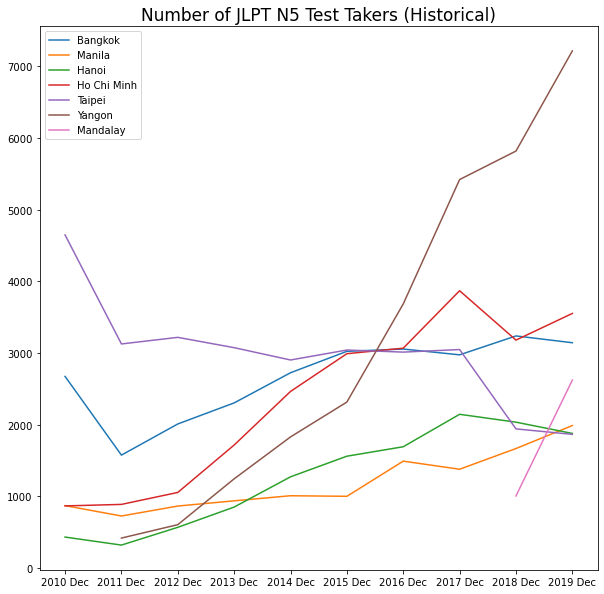

In [601]:
# Set top X below
X = 7

topX_historical = df_jlpt2[df_jlpt2["city_en"].isin(top20.iloc[-X:]["city_en"])][["city_en","n5_tstaken", "file"]]
plt.figure(figsize=(10, 10))

for city in topX_historical["city_en"].unique():
    topXtemp = topX_historical[topX_historical["city_en"]==city]
    plt.plot(topXtemp["file"], topXtemp["n5_tstaken"], label=city)

plt.legend()
plt.title("Number of JLPT N5 Test Takers (Historical)", fontsize=17)
plt.show()

Seeing the explosion in the number of test takers in Yangon and Mandalay, we can tell that the growth seen above is driven by the demand in Myanmar. Ho Chi Minh growth was also remarkable between 2012 and 2017.
In the other hand, test takers in Taipei is declining.

Interesting to how demand is growing in Asia. Now Let me check the number of tast takers in Latin America (out of my own curiosity)

In [488]:
# Latin American cities (13 cities)
latam = ["Mexico City","Monterrey","Buenos Aires","Montevideo","Quito","Bogota","Santiago","Asuncion",
         "Amambay","Iguazu","Encarnacion","Pirapo","Sao Paulo","Londrina","Belem","Rio de Janeiro","Porto Alegre",
         "Brasilia","Salvador","Manaus","Lima"]

In [489]:
df_jlpt_latam = df_jlpt2[df_jlpt2["city_en"].isin(latam)]
df_jlpt_latam

,city_jp,city_en,n1_applied,n1_tstaken,n2_applied,n2_tstaken,n3_applied,n3_tstaken,n4_applied,n4_tstaken,n5_applied,n5_tstaken,file
154,メキシコ・シティー,Mexico City,31,28,64,57,223,204,385,353,709,635,2010 Dec
155,ブエノスアイレス,Buenos Aires,24,22,45,42,101,91,167,147,324,279,2010 Dec
156,ボゴタ,Bogota,1,1,4,4,9,8,7,7,33,33,2010 Dec
157,アスンシオン,Asuncion,30,28,15,15,58,53,49,44,78,61,2010 Dec
158,アマンバイ,Amambay,21,20,6,6,31,27,34,27,27,24,2010 Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,ポルトアレグレ,Porto Alegre,12,9,20,16,34,27,54,48,78,70,2019 Dec
2509,ブラジリア,Brasilia,19,17,26,22,74,63,76,68,84,66,2019 Dec
2510,サルバドール,Salvador,6,5,6,6,14,11,23,18,41,38,2019 Dec
2511,マナウス,Manaus,8,8,11,11,15,13,28,25,78,63,2019 Dec


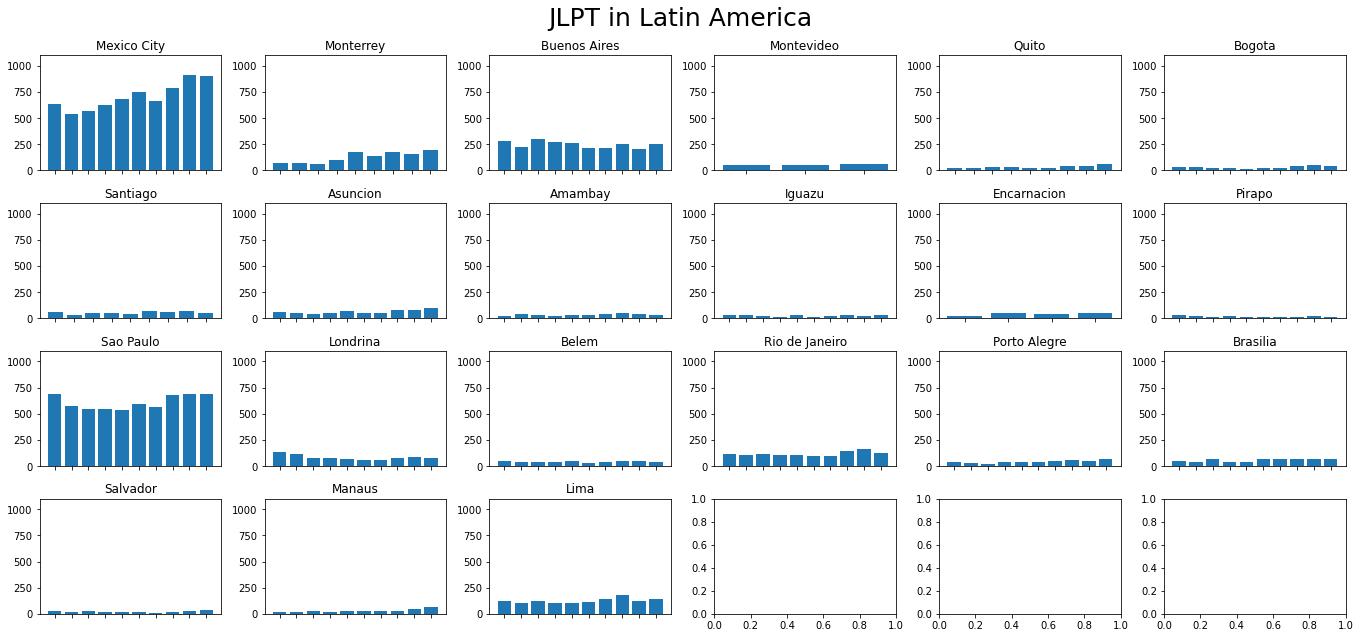

In [609]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4,6, figsize=(19, 9))
fig.suptitle('JLPT in Latin America', fontsize=25)

for ax, latam_city in zip(axs.ravel(), latam):
    temp_df = df_jlpt_latam[df_jlpt_latam["city_en"]==latam_city]
    ax.bar(temp_df["file"], temp_df["n5_tstaken"])
    ax.set_ylim(0,1100)
    ax.set_title(latam_city)
    ax.set_xticklabels([])
plt.tight_layout()

Brazil has one of the largest community of ethnic Japanese outside Japan. Demand for Japanese language education ranges between 500-700 test takers for N5 - which is is relatively high: comparable to Seoul, Kuala Kumpur, Mumbai, and other Asian cities - but the historical trend shows that demand is stagnant. It was a suprise to find out that Mexico City has surpassed Sao Paulo in the number of test takers.

This is the end of this Python Notebook. Further data exploration will be done in Tableau (way easier to explore data than matplotlib).